In [1]:
import numpy as np
from scipy.spatial.distance import euclidean
import scipy
import torch

import dtw
from fastdtw import fastdtw
import dtwalign

from src.speech_classification.audio_processing import AudioPreprocessorFbank, SpeechCommandsDataCollector
from src.siamese_net_sound_similarity.slstm_train import SiameseSpeechCommandsDataCollector, StochasticSiameseLSTMNet
from src.siamese_net_sound_similarity.train import SiameseLSTMNet


import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()

%matplotlib inline

## Load data

In [2]:
wanted_words = ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left',
                'marvin',
                'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two',
                'up', 'wow', 'yes', 'zero']

wanted_words_combined = wanted_words

model_settings = {
    'dct_coefficient_count': 26,
    'label_count': len(wanted_words_combined) + 2,
    'hidden_reccurent_cells_count': 128,
    'winlen': 0.04,
    'winstep': 0.02
}

In [3]:
preproc = AudioPreprocessorFbank(nfilt=model_settings['dct_coefficient_count'], winlen=model_settings['winlen'],
                                     winstep=model_settings['winstep'])

data_iter = SiameseSpeechCommandsDataCollector(preproc,
                                        data_dir=r'C:\Study\Speech_command_classification\speech_dataset',
                                        wanted_words=wanted_words_combined,
                                        testing_percentage=10,
                                        validation_percentage=10
                                        )

index_to_word = {v:k for k,v in data_iter.word_to_index.items()}

In [4]:
n_mini_batch_size = 1000
data = data_iter.get_data(n_mini_batch_size, 0, 'training')
labels = data['y']

duplicates = data_iter.get_duplicates(labels, 0, 'training')
assert np.any(labels == duplicates['y'])

non_duplicates = data_iter.get_nonduplicates(labels, 0, 'training')
assert np.any(labels != non_duplicates['y'])

## DTW distribution on raw data

In [5]:
# load nn

nn_fname = r'C:/Study/SpeechAcquisitionModel/reports/seamise_net_09_17_2019_12_20_PM/net_0.97265625.net'

nn = torch.load(nn_fname)

In [6]:
nn_input = torch.from_numpy(data['x'][:, :10, :]).cuda().float()

In [7]:
z, *_ = nn.single_forward(nn_input)
z = z.detach().cpu().numpy()

duplicates_z, *_ = nn.single_forward(torch.from_numpy(duplicates['x']).cuda().float())
duplicates_z = duplicates_z.detach().cpu().numpy()

non_duplicates_z, *_ = nn.single_forward(torch.from_numpy(non_duplicates['x']).cuda().float())
non_duplicates_z = non_duplicates_z.detach().cpu().numpy()

In [8]:
# random latent variables
# z, _, _, _ = nn.single_forward(nn_input)
# z = z.detach().cpu().numpy()

# duplicates_z, _, _, _ = nn.single_forward(torch.from_numpy(duplicates['x']).cuda().float())
# duplicates_z = duplicates_z.detach().cpu().numpy()

# non_duplicates_z, _, _, _ = nn.single_forward(torch.from_numpy(non_duplicates['x']).cuda().float())
# non_duplicates_z = non_duplicates_z.detach().cpu().numpy()

0.0
1.4234426701441407
0.8179927188903093


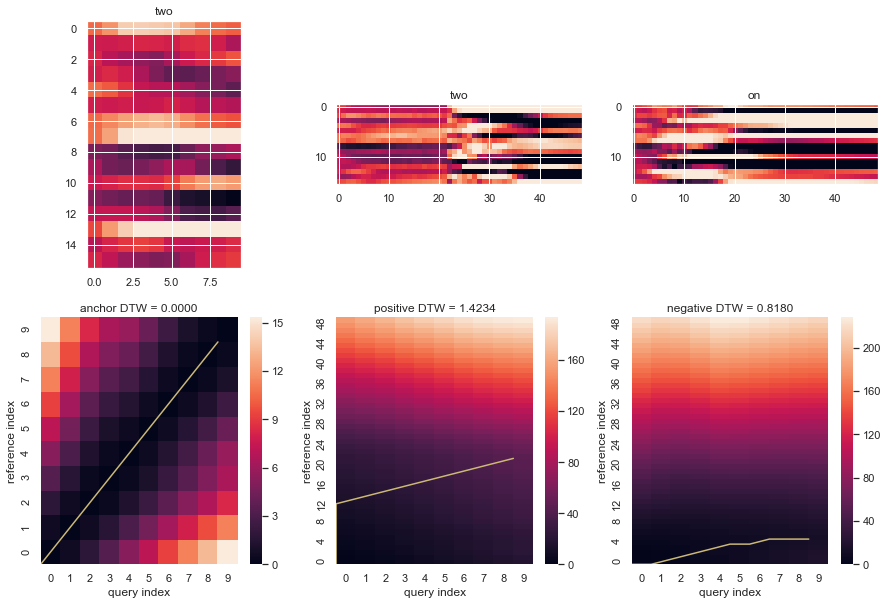

In [17]:

i = np.random.randint(data['y'].shape[0])
sample_idx = i

fig, axes = plt.subplots(2, 3, figsize=(15,10))

# plt.figure()
im = axes[0][0].imshow(z[i].T, vmin=-1, vmax=1)
# fig.colorbar(im)
label = index_to_word[data['y'][i]]
axes[0][0].title.set_text(f'{label}')

axes[0][1].imshow(duplicates_z[i].T, vmin=-1, vmax=1)
# plt.colorbar()
label = index_to_word[data['y'][i]]
axes[0][1].title.set_text(f'{label}')


axes[0][2].imshow(non_duplicates_z[i].T, vmin=-1, vmax=1)
# plt.colorbar()
label = index_to_word[non_duplicates['y'][i]]
axes[0][2].title.set_text(f'{label}')

######################################## DTW

x = z[sample_idx]

# self dtw (extpected to be 0)

y = z[sample_idx]
res = dtwalign.dtw(x, y, dist=euclidean, open_end=True)

res.plot_path(ax=axes[1][0])
axes[1][0].set_title(f"anchor DTW = {res.normalized_distance:.4f}")
print(res.normalized_distance)
# axes[1][0].imshow(res[1].T)
# axes[1][0].plot(res[3][0], res[3][1], color='r')
# axes[1][0].title.set_text(f'same signal distance:\n {res.distance}')
# print('duplicates optimal path')
# print(list(zip(*res[3])))

# duplicates dtw

y = duplicates_z[sample_idx]
res = dtwalign.dtw(x, y, dist=euclidean, open_end=True)
res.plot_path(ax=axes[1][1])
axes[1][1].set_title(f"positive DTW = {res.normalized_distance:.4f}")
print(res.normalized_distance)
# # plt.figure()
# axes[1][1].imshow(res[1].T)
# axes[1][1].plot(res[3][0], res[3][1], color='r')
# axes[1][1].title.set_text(f'duplicates distance:\n {res.distance}')
# print('duplicates optimal path')
# # print(list(zip(*res[3])))


# non-duplicates dtw

y = non_duplicates_z[sample_idx]
res = dtwalign.dtw(x, y, dist=euclidean, open_end=True)
res.plot_path(ax=axes[1][2])
axes[1][2].set_title(f"negative DTW = {res.normalized_distance:.4f}")
print(res.normalized_distance)
# # plt.figure()
# axes[1][2].imshow(res[1].T)
# axes[1][2].plot(res[3][0], res[3][1], color='r')
# axes[1][2].title.set_text(f'non-duplicates distance:\n {res.distance}')
# print('non-duplicates optimal path')
# # print(list(zip(*res[3])))

# 2. DTW (prefix case n << m)

In [10]:
PREFIX_LEN = 10

## DTW distribution on raw data

In [51]:

# initialize dist_lists
data_shorten = {}
data_shorten['x'] = data['x'][:, :PREFIX_LEN, :]   

In [52]:
nn_input = torch.from_numpy(data_shorten['x']).cuda().float()

In [53]:
z, *_ = nn.single_forward(nn_input)
z = z.detach().cpu().numpy()

duplicates_z, *_ = nn.single_forward(torch.from_numpy(duplicates['x'][:, :PREFIX_LEN, :]).cuda().float())
duplicates_z = duplicates_z.detach().cpu().numpy()

non_duplicates_z, *_ = nn.single_forward(torch.from_numpy(non_duplicates['x'][:, :PREFIX_LEN, :]).cuda().float())
non_duplicates_z = non_duplicates_z.detach().cpu().numpy()

In [54]:
# random latent variables
# z, _, _, _ = nn.single_forward(nn_input)
# z = z.detach().cpu().numpy()

# duplicates_z, _, _, _ = nn.single_forward(torch.from_numpy(duplicates['x']).cuda().float())
# duplicates_z = duplicates_z.detach().cpu().numpy()

# non_duplicates_z, _, _, _ = nn.single_forward(torch.from_numpy(non_duplicates['x']).cuda().float())
# non_duplicates_z = non_duplicates_z.detach().cpu().numpy()

duplicates optimal path
duplicates optimal path
non-duplicates optimal path


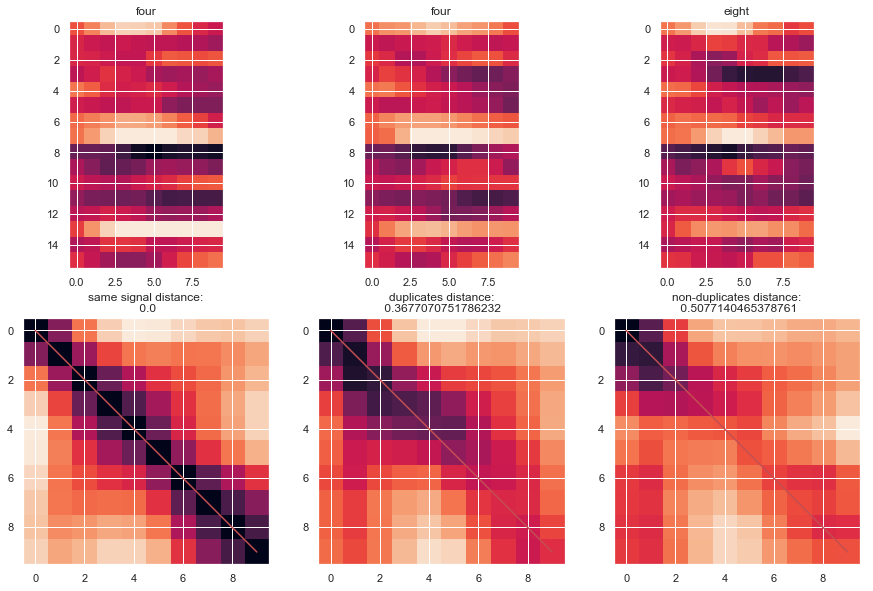

In [62]:

i = np.random.randint(data['y'].shape[0])
sample_idx = i

fig, axes = plt.subplots(2, 3, figsize=(15,10))

# plt.figure()
im = axes[0][0].imshow(z[i].T, vmin=-1, vmax=1)
# fig.colorbar(im)
label = index_to_word[data['y'][i]]
axes[0][0].title.set_text(f'{label}')

axes[0][1].imshow(duplicates_z[i].T, vmin=-1, vmax=1)
# plt.colorbar()
label = index_to_word[data['y'][i]]
axes[0][1].title.set_text(f'{label}')


axes[0][2].imshow(non_duplicates_z[i].T, vmin=-1, vmax=1)
# plt.colorbar()
label = index_to_word[non_duplicates['y'][i]]
axes[0][2].title.set_text(f'{label}')

######################################## DTW

x = z[sample_idx]

# self dtw (extpected to be 0)

y = z[sample_idx]
res = dtw.dtw(x, y, dist=euclidean)

axes[1][0].imshow(res[1].T)
axes[1][0].plot(res[3][0], res[3][1], color='r')
axes[1][0].title.set_text(f'same signal distance:\n {res[0]}')
print('duplicates optimal path')
# print(list(zip(*res[3])))

# duplicates dtw

y = duplicates_z[sample_idx]
res = dtw.dtw(x, y, dist=euclidean)

# plt.figure()
axes[1][1].imshow(res[1].T)
axes[1][1].plot(res[3][0], res[3][1], color='r')
axes[1][1].title.set_text(f'duplicates distance:\n {res[0]}')
print('duplicates optimal path')
# print(list(zip(*res[3])))


# non-duplicates dtw

y = non_duplicates_z[sample_idx]
res = dtw.dtw(x, y, dist=euclidean)

# plt.figure()
axes[1][2].imshow(res[1].T)
axes[1][2].plot(res[3][0], res[3][1], color='r')
axes[1][2].title.set_text(f'non-duplicates distance:\n {res[0]}')
print('non-duplicates optimal path')
# print(list(zip(*res[3])))

# DTW distribution in latent space z

In [41]:

# initialize dist_lists

duplicates_dtw_z = []
non_duplicates_dtw_z = []

for i in range(n_mini_batch_size):
    print(i, end='\r')
    x = z[i].squeeze()
    
    y_duplicate = duplicates_z[i].squeeze()
    duplicates_dtw_z.append(dtw.dtw(x, y_duplicate, dist=euclidean)[0])

    y_non_duplicate = non_duplicates_z[i].squeeze()
    non_duplicates_dtw_z.append(dtw.dtw(x, y_non_duplicate, dist=euclidean)[0])    

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\bandwidths.py:22: RuntimeWarning: invalid value encountered in minimum
  return np.minimum(np.std(X, axis=0, ddof=1), IQR)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarnin

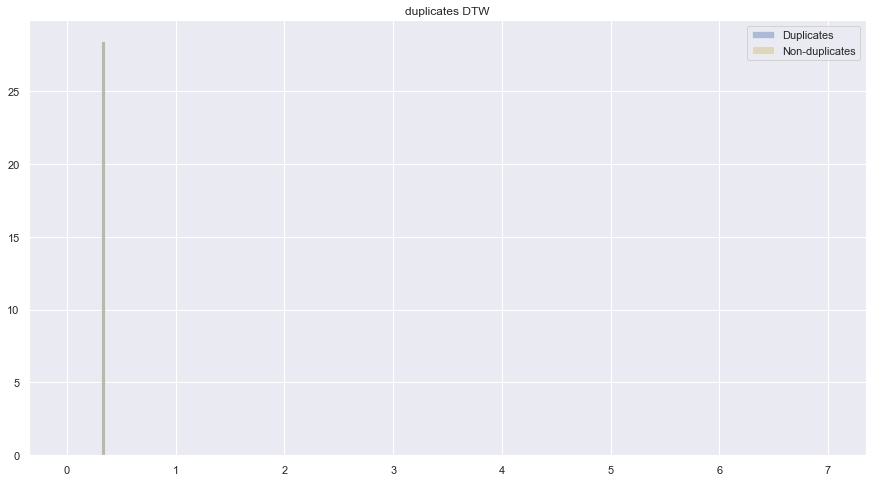

DKL is: 0.0000


In [42]:
bins = np.linspace(0, 7, 200)
fig, axes = plt.subplots(1, 1, figsize=(15,8))

sns.distplot(duplicates_dtw_z, bins=bins, ax=axes, label="Duplicates")
axes.title.set_text('duplicates DTW')

sns.distplot(non_duplicates_dtw_z, bins=bins, color='y', ax=axes, label='Non-duplicates')
axes.legend()
# axes[1].title.set_text('non-duplicates DTW')
plt.show()

hist_dup, _ = np.histogram(duplicates_dtw_z, bins=bins)
hist_dup = hist_dup / np.sum(hist_dup)

hist_non_dup, _ = np.histogram(non_duplicates_dtw_z, bins=bins)
hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
print(f"DKL is: {dkl:.4f}")

## Disctance between very last frames of samples

In [140]:

# initialize dist_lists

duplicates_last_dtw_z = []
non_duplicates_last_dtw_z = []

for i in range(n_mini_batch_size):
    print(i, end='\r')
    x = z[i][-1, :].squeeze()
    
    y_duplicate = duplicates_z[i][-1, :].squeeze()
    duplicates_last_dtw_z.append(dtw.dtw(x, y_duplicate, dist=euclidean)[0])

    y_non_duplicate = non_duplicates_z[i][-1, :].squeeze()
    non_duplicates_last_dtw_z.append(dtw.dtw(x, y_non_duplicate, dist=euclidean)[0])    


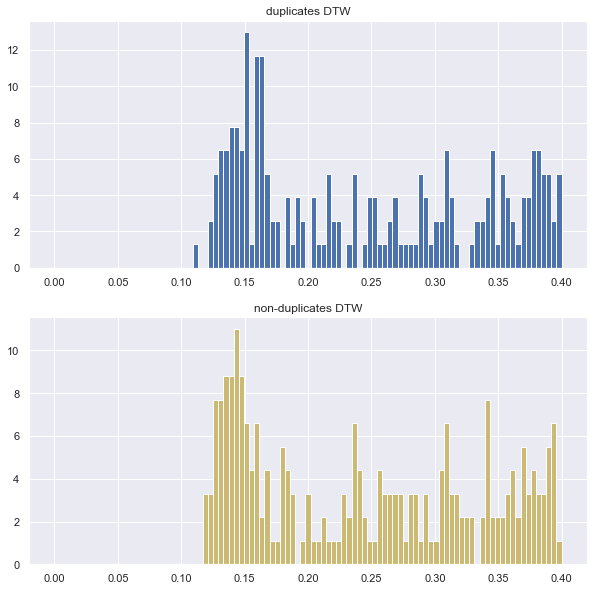

DKL is: 0.5229


In [141]:

bins = np.linspace(0, 0.4, 100)
fig, axes = plt.subplots(2, 1, figsize=(10,10))

axes[0].hist(duplicates_last_dtw_z, bins=bins,density=True)
axes[0].title.set_text('duplicates DTW')

axes[1].hist(non_duplicates_last_dtw_z, bins=bins, color='y', density=True)
axes[1].title.set_text('non-duplicates DTW')
plt.show()

hist_dup, _ = np.histogram(duplicates_last_dtw_z, bins=bins)
hist_dup = hist_dup / np.sum(hist_dup)

hist_non_dup, _ = np.histogram(non_duplicates_last_dtw_z, bins=bins)
hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
print(f"DKL is: {dkl:.4f}")
